# LangGraph 에이전트
## 도구 없음

## 라이브러리 임포트

In [1]:
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
import logging
from IPython.display import Image, Markdown, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


from swc_toolkit import SportsWorldCentralToolkit
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

SWC_API_BASE_URL in SWCConfig init: http://0.0.0.0:8000


## 로깅 설정

In [2]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename='langgraph_notebook.log',  
    level=logging.INFO,
)

## 툴킷 생성

In [3]:
swc_toolkit = SportsWorldCentralToolkit()
tools = swc_toolkit.get_tools()

## 에이전트와 모델 설정

In [4]:
tool_node = ToolNode(tools)

model = ChatAnthropic(model="claude-sonnet-4-20250514", 
                      temperature=0).bind_tools(tools)
# 책을 번역할 당시의 Anthropic 모델은 'claude-3-5-sonnet-20240620'이었지만, 현재는 위 모델로 업데이트 되었습니다.

def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)


## 그래프 시각화하기

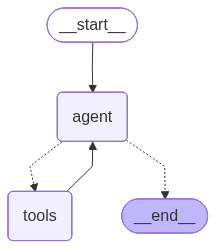

In [5]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## 에이전트와 대화하기

In [6]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="What are the leagues in the SportsWorldCentral fantasy football platform? Keep the response simple.")]},
    config={"configurable": {"thread_id": 99}}
)
display(Markdown(final_state["messages"][-1].content))

The SportsWorldCentral fantasy football platform has 5 leagues:

1. **Pigskin Prodigal Fantasy League** (PPR scoring)
2. **Recurring Champions League** (Half-PPR scoring)  
3. **AHAHFZZFFFL** (Half-PPR scoring)
4. **Gridiron Gurus Fantasy League** (PPR scoring)
5. **Best League Ever** (PPR scoring)

In [7]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="SportsWorldCentral 판타지 풋볼 플랫폼에는 어떤 리그들이 있나요? 답변은 간단하게 해주세요.")]},
    config={"configurable": {"thread_id": 99}}
)
display(Markdown(final_state["messages"][-1].content))

SportsWorldCentral 판타지 풋볼 플랫폼에는 총 5개의 리그가 있습니다:

1. **Pigskin Prodigal Fantasy League** (PPR 방식)
2. **Recurring Champions League** (Half-PPR 방식)
3. **AHAHFZZFFFL** (Half-PPR 방식)
4. **Gridiron Gurus Fantasy League** (PPR 방식)
5. **Best League Ever** (PPR 방식)